# Example 5 - Plug flow reactor yield

In this example, we will demonstrate how Bayesian Optimization can locate the optimal conditions for a plug flow reactor (PFR) and produce the maximum yield. The PFR model is developed for the acid-catalyzed dehydration of fructose to HMF using HCl as the catalyst. 


The analytical form of the objective function is encoded in the PFR model. It is a set of ordinary differential equations (ODEs). The input parameters (`X`) are 

- T - reaction temperature (°C)
- pH - reaction pH 
- tf - final residence time (min)

At each instance, the PFR model solves the ODEs and would return the steady state yield, i.e, the reponse `Y`.

The computational cost to solve the objective function is high. As a result, the trained Gaussian Process (GP) serves as an efficient surrogate model for prediction tasks. 

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :---------------------------- |
| Goal | Maximization |
| Objective function | PFR model |
| Input (X) dimension | 3 |
| Output (Y) dimension | 1 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Full factorial, latin hypercube or random sampling | 

Next, we will go through each step in Bayesian Optimization.


## 1. Import `nextorch` and other packages

In [11]:
import os
import sys
import time
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '..\..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)

import numpy as np
from nextorch import plotting, bo, doe, utils, io

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR_yield` as the objective function `objective_func`. 
Note that it is suggested to put the return values of the objective function as a 2D numpy matrix instead of a 1D numpy array. We use `Y_real = np.expand_dims(Y_real, axis=1)` to expand the output's dimension.

The ranges of the input X are specified. 

In [12]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR_yield(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield 
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi, _ = Reactor(**Conditions) # only keep the first output       
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
    # Put y in a column
    Y_real = np.expand_dims(Y_real, axis=1)
        
    return Y_real # yield

# Objective function
objective_func = PFR_yield


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# One output
Y_name_with_unit = 'Yield %'

# combine X and Y names
var_names = X_name_with_unit + [Y_name_with_unit]

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  

# Set the reponse range
Y_plot_range = [0, 50]

# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = 1 # the dimension of outputs

## 3. Define the initial sampling plan
Here we compare 3 sampling plans with the same number of sampling points:

1. Full factorial (FF) design with levels of 4 and 64 points in total. 
2. Latin hypercube (LHC) design with 10 initial sampling points, and 54 more Bayesian Optimization trials
3. Completely random (RND) samping with 64 points

The initial reponse in a real scale `Y_init_real` is computed from the helper function `bo.eval_objective_func(X_init, X_ranges, objective_func)`, given `X_init` in unit scales. It might throw warning messages since the model solves some edge cases of ODEs given certain input combinations. 

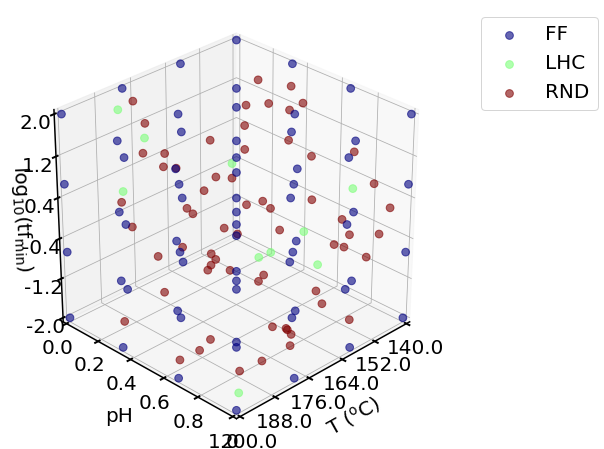

In [13]:
#%% Initial Sampling 
# Full factorial design 
n_ff_level = 4
n_total = n_ff_level**n_dim

X_ff = doe.full_factorial([n_ff_level, n_ff_level, n_ff_level])
# Get the initial responses
Y_ff = bo.eval_objective_func(X_ff, X_ranges, objective_func)

# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Completely random design 
X_rnd = doe.randomized_design(n_dim=n_dim, n_points=n_total, seed=1)
# Get the responses
Y_rnd = bo.eval_objective_func(X_rnd, X_ranges, objective_func)


# Compare the 3 sampling plans
plotting.sampling_3d([X_ff, X_init_lhc, X_rnd], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC', 'RND'])

## 4. Initialize an `Experiment` object 

Next, we initialize 3 `Experiment` objects for FF, LHC and random sampling, respectively. We also set the objective function and the goal as maximization. 

We will train 3 GP models. Some progress status will be printed out.



In [14]:
#%% Initialize an Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_ff = bo.Experiment('PFR_yield_ff') 
# Import the initial data
Exp_ff.input_data(X_ff, Y_ff, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_ff.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)


# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.Experiment('PFR_yield_lhc') 
# Import the initial data
Exp_lhc.input_data(X_init_lhc, Y_init_lhc, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)


# Set its name, the files will be saved under the folder with the same name
Exp_rnd = bo.Experiment('PFR_yield_rnd') 
# Import the initial data
Exp_rnd.input_data(X_rnd, Y_rnd, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_rnd.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

Iter 10/100: 1.5686978101730347
Iter 20/100: 1.4323296546936035
Iter 30/100: 1.2134912014007568
Iter 40/100: 0.7860245108604431
Iter 50/100: 0.7257839441299438
Iter 10/100: 2.1498355865478516
Iter 20/100: 2.020167589187622
Iter 30/100: 1.9116523265838623
Iter 40/100: 1.810738205909729
Iter 10/100: 1.5580168962478638
Iter 20/100: 1.4106810092926025
Iter 30/100: 1.1793935298919678
Iter 40/100: 0.8040145039558411


## 5. Run trials 
We perform 54 more Bayesian Optimization trials for the LHC design using the default acquisition function (Expected Improvement (EI)). 

In [15]:
#%% Optimization loop
# Set the number of iterations  
n_trials_lhc = n_total - n_init_lhc
for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point()
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func(X_new, X_ranges, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)

Iter 10/100: 1.7697422504425049
Iter 20/100: 1.7688804864883423
Iter 10/100: 1.7285405397415161
Iter 20/100: 1.7251774072647095
Iter 30/100: 1.724414348602295
Iter 40/100: 1.7239428758621216
Iter 10/100: 1.7716680765151978
Iter 20/100: 1.7642356157302856
Iter 30/100: 1.7632038593292236
Iter 10/100: 1.736713171005249
Iter 10/100: 1.6159178018569946
Iter 10/100: 1.541394591331482
Iter 10/100: 1.463523268699646
Iter 10/100: 1.358145833015442
Iter 10/100: 0.9404640197753906
Iter 20/100: 0.9380767345428467
Iter 10/100: 0.7795146703720093
Iter 10/100: 0.7422641515731812
Iter 20/100: 0.7413120269775391
Iter 30/100: 0.7410898208618164
Iter 10/100: 0.7823007702827454
Iter 20/100: 0.7810778021812439
Iter 30/100: 0.7806760668754578
Iter 10/100: 0.8384299278259277
Iter 10/100: 0.8313624858856201
Iter 20/100: 0.8311166763305664
Iter 10/100: 0.6713908314704895
Iter 10/100: 0.6647385954856873
Iter 20/100: 0.6646579504013062
Iter 10/100: 0.6817567348480225
Iter 20/100: 0.6811261773109436
Iter 10/100: 

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Iter 10/100: 0.5026893019676208
Iter 20/100: 0.5023985505104065
Iter 10/100: 0.510124921798706
Iter 10/100: 0.4373466968536377
Iter 20/100: 0.437200129032135
Iter 10/100: 0.33615368604660034
Iter 10/100: 0.37633246183395386
Iter 10/100: 0.4235653877258301
Iter 10/100: 0.4237906336784363
Iter 10/100: 0.5078677535057068
Iter 20/100: 0.5071730017662048
Iter 10/100: 0.5106713771820068
Iter 10/100: 0.4835512936115265
Iter 10/100: 0.4513150155544281
Iter 10/100: 0.4023396074771881
Iter 10/100: 0.4127748906612396
Iter 10/100: 0.3913898468017578
Iter 10/100: 0.35759228467941284
Iter 20/100: 0.35730284452438354
Iter 10/100: 0.31954675912857056
Iter 20/100: 0.3191703259944916
Iter 10/100: 0.30319422483444214
Iter 10/100: 0.2574177086353302
Iter 10/100: 0.2216109335422516
Iter 10/100: 0.16472913324832916
Iter 10/100: 0.10401909053325653
Iter 10/100: 0.06188894063234329
Iter 10/100: 0.011676357127726078
Iter 10/100: -0.028680723160505295
Iter 10/100: -0.07515107095241547
Iter 10/100: -0.0568148307

## 6. Visualize the final model reponses
We would like to see how sampling points scattered in the 3D space. A 2D slices of the 3D space is visualized below at a fixed x value . 

LHC sampling points


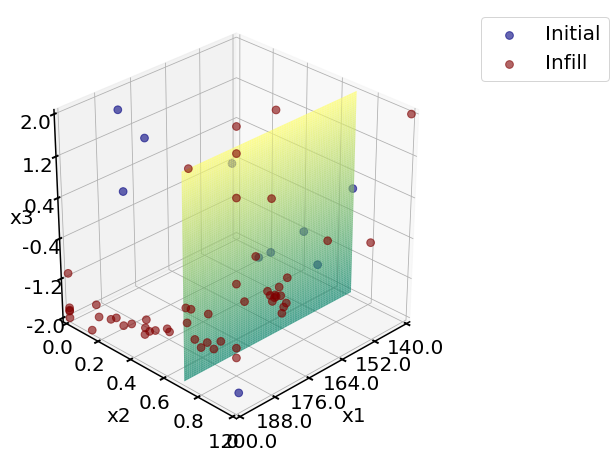

Comparing 3 plans: 


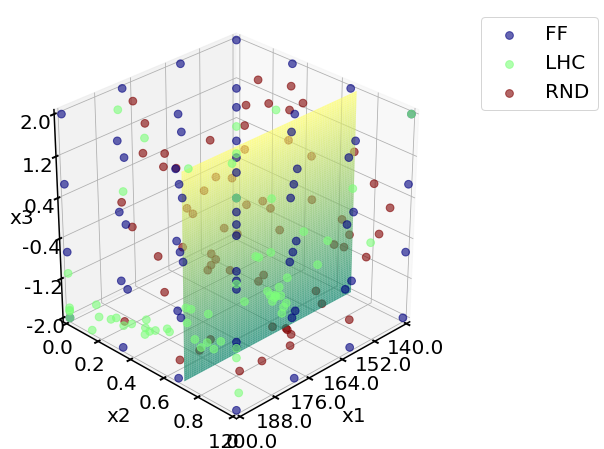

In [16]:
#%% plots 
# Check the sampling points
# Final lhc Sampling
x2_fixed_real = 0.7 # fixed x2 value
x_indices = [0, 2] # 0-indexing, for x1 and x3
print('LHC sampling points')
plotting.sampling_3d_exp(Exp_lhc, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    
                         
# Compare 3 sampling plans
print('Comparing 3 plans: ')
plotting.sampling_3d([Exp_ff.X, Exp_lhc.X, Exp_rnd.X], 
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC', 'RND'],
                     slice_axis = 'y', 
                     slice_value_real = x2_fixed_real)

By fixing the value of pH (`x2`), we can plot the 2D reponse surfaces by varying T (`x1`) and tf (`x3`). It takes a long time to get the reponses from the objective function. 

To create a heatmap, we generate `mesh_size` (by default = 41, here we set it as 20) test points along one dimension. For a 2D mesh, 20 by 20, i.e. 400 times of evaluation is needed. The following code indicates that evaluting the GP surrogate model is much faster than calling the objective function. 

Objective function heatmap: 


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


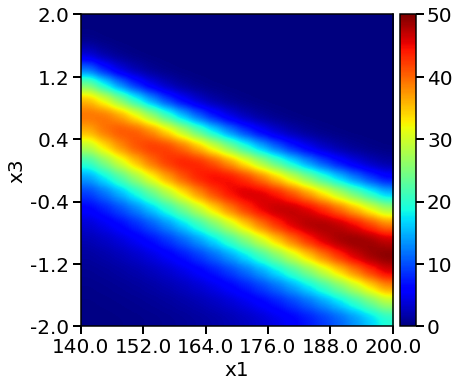

Evaluation of objective function 400 times takes 0.16 min

Full factorial model heatmap: 


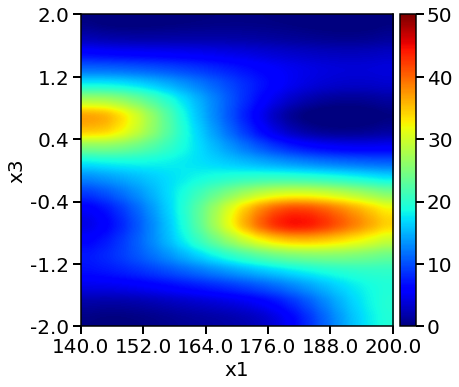

Evaluation of FF GP model 400 times takes 0.00 min

LHC model heatmap: 


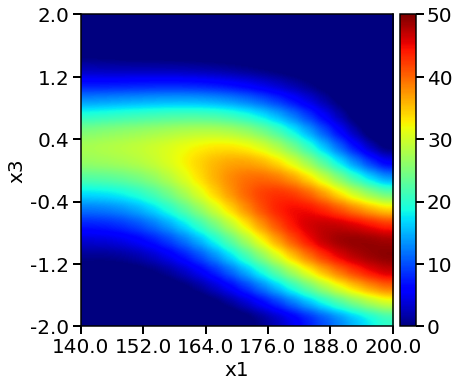

Evaluation of LHC GP model 400 times takes 0.00 min

RND model heatmap: 


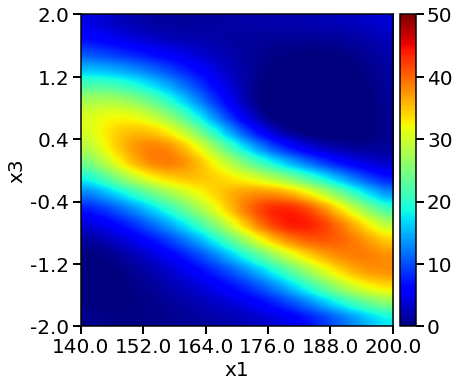

Evaluation of RND GP model 400 times takes 0.00 min



In [17]:
# Reponse heatmaps
# Set X_test mesh size
mesh_size = 20
n_test = mesh_size**2

# Objective function heatmap
# (this takes a long time)
print('Objective function heatmap: ')
start_time = time.time()
plotting.objective_heatmap(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real,
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# full factorial heatmap
print('Full factorial model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_ff, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of FF GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60)) 


# LHC heatmap 
print('LHC model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# random sampling heatmap 
print('RND model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_rnd, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of RND GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

The rates can also be plotted as response surfaces in 3D.

Objective function surface: 


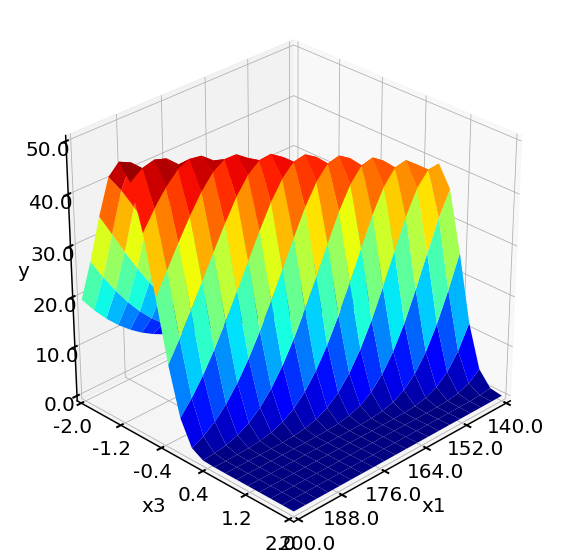

Evaluation of objective function 400 times takes 0.16 min

LHC model surface: 


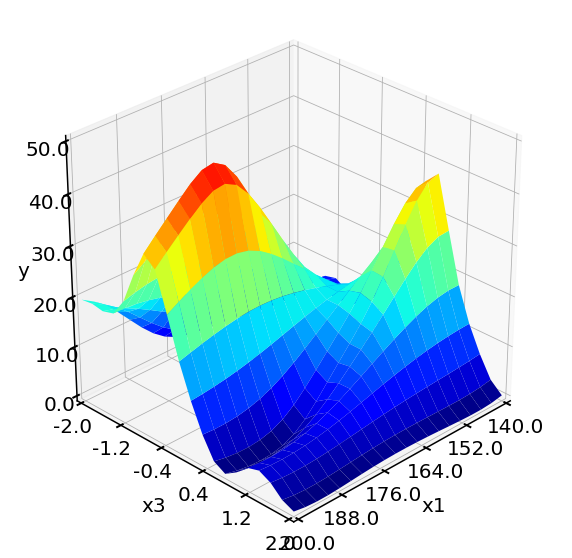

Evaluation of FF GP model 400 times takes 0.00 min

Full fatorial model surface: 


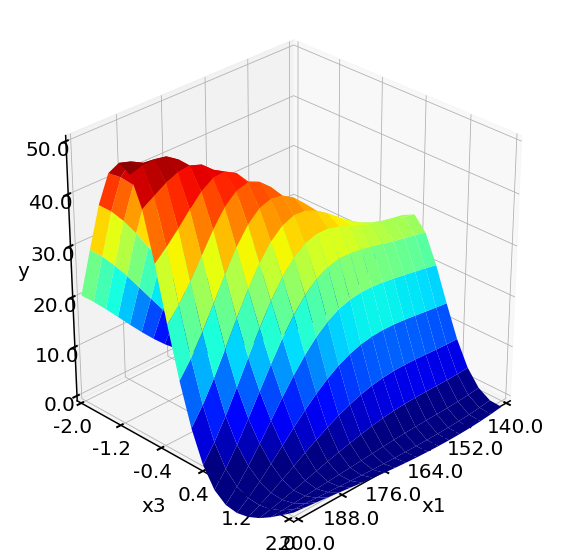

Evaluation of LHC GP model 400 times takes 0.00 min

RND model surface: 


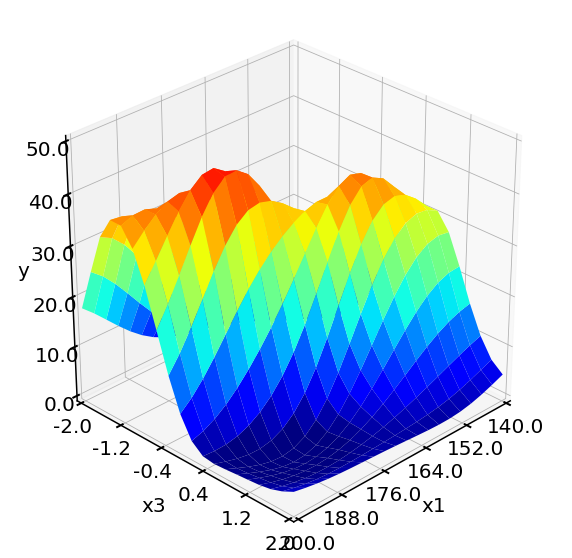

Evaluation of RND GP model 400 times takes 0.00 min



In [18]:
# Suface plots   
# Objective function surface plot  
#(this takes a long time)
print('Objective function surface: ')
start_time = time.time()
plotting.objective_surface(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real, 
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# full fatorial surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_ff, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of FF GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60)) 


# LHC surface plot
print('Full fatorial model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# random sampling surface plot
print('RND model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_rnd, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of RND GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60)) 



## 7. Export the optimum

Compare two plans in terms optimum discovered in each trial.

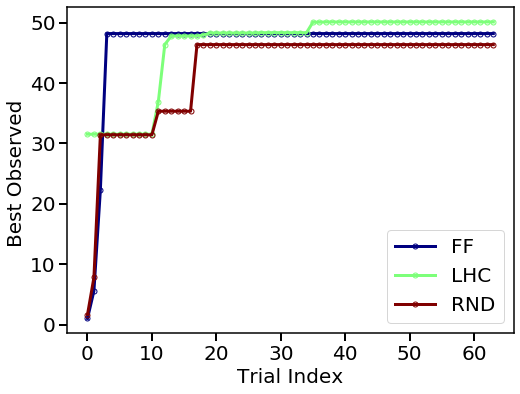

In [19]:
plotting.opt_per_trial([Exp_ff.Y_real, Exp_lhc.Y_real, Exp_rnd.Y_real], 
                       design_names = ['FF', 'LHC', 'RND'])

Obtain the optimum from each method. 

In [20]:
# full factorial optimum
y_opt_ff, X_opt_ff, index_opt_ff = Exp_ff.get_optim()
data_opt_ff = io.np_to_dataframe([X_opt_ff, y_opt_ff], var_names)

print('From full factorial design, ')
display(data_opt_ff)


# lhc optimum
y_opt_lhc, X_opt_lhc, index_opt_lhc = Exp_lhc.get_optim()
data_opt_lhc = io.np_to_dataframe([X_opt_lhc, y_opt_lhc], var_names)

print('From LHC + Bayesian Optimization, ')
display(data_opt_lhc)


# random sampling optimum
y_opt_rnd, X_opt_rnd, index_opt_rnd = Exp_rnd.get_optim()
data_opt_rnd = io.np_to_dataframe([X_opt_rnd, y_opt_rnd], var_names)

print('From random sampling, ')
display(data_opt_rnd)


From full factorial design, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,200.0,0.0,-2.0,48.179909


From LHC + Bayesian Optimization, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,200.0,0.0,-1.843421,50.101679


From random sampling, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,180.730132,0.211628,-0.937813,46.353722


From above plots, we see the response surface produced by LHC + Bayesian Optimization is more accurate and resembles the one from the objective function. The method also locates a higher yield value compared to designs. We can conclude that LHC + Bayesian Optimization is efficient in locating the optimum and produce accurate surrogate models at affordable computational cost. 

## References:
1. Desir, P.; Saha, B.; Vlachos, D. G. Energy Environ. Sci. 2019.

2. Swift, T. D.; Bagia, C.; Choudhary, V.; Peklaris, G.; Nikolakis, V.; Vlachos, D. G. ACS Catal. 2014, 4 (1), 259–267

3. The PFR model can be found on GitHub: https://github.com/VlachosGroup/Fructose-HMF-Model